In [2]:
#connect to database

import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image




connection = pymysql.connect(
    # host='192.168.208.1',
    host='192.168.11.6',
    user='root', 
    password='water',
    database='waterdata',
    port=30000)


dt = 0.01

try:
    with connection.cursor() as cursor:
               
        sql1 = ('''  SELECT 
                        `A`.`read_date`, `A`.`meter_no` AS `bl_meter1`, `A`.`bl_ahd` AS `bl_ahd1`, 
                        `B`.`meter_no` AS `bl_meter2`, `B`.`bl_ahd` AS `bl_ahd2`,
                        `C`.`meter_no` AS `meter_no3`, `C`.`sl_read1` AS `sl_read1`,
                        `D`.`meter_no` AS `meter_no4`, `D`.`rf_read1` AS `rf_read1`
                    FROM   
                        `groundwater` AS `A`  
                    INNER JOIN
                        `groundwater` `B` ON (`B`.`meter_no` = "GW967137.2.2" AND `B`.`read_date` = `A`.`read_date` )
                    INNER JOIN
                        `surfacewater` `C` ON (`C`.`meter_no` = "CF419051" AND `C`.`read_date` = `A`.`read_date` )
                    INNER JOIN
                        `rainfall` `D` ON (`D`.`meter_no` = "54151" AND `D`.`read_date` = `A`.`read_date` )
                    WHERE  
                        `A`.`meter_no` = "GW967137.1.1"
                    ''')
        
        
        sql2 = ('''  SELECT 
                        `A`.`read_date`, `A`.`meter_no` AS `bl_meter1`, `A`.`bl_ahd` AS `bl_ahd1`, 
                        `B`.`meter_no` AS `bl_meter2`, `B`.`bl_ahd` AS `bl_ahd2`,
                        `C`.`meter_no` AS `meter_no3`, `C`.`sl_read1` AS `sl_read1`,
                        `D`.`meter_no` AS `meter_no4`, `D`.`rf_read1` AS `rf_read1`
                    FROM   
                        `groundwater` AS `A`  
                    INNER JOIN
                        `groundwater` `B` ON (`B`.`meter_no` = "GW967138.2.2" AND `B`.`read_date` = `A`.`read_date` )
                    INNER JOIN
                        `surfacewater` `C` ON (`C`.`meter_no` = "CF419051" AND `C`.`read_date` = `A`.`read_date` )
                    INNER JOIN
                        `rainfall` `D` ON (`D`.`meter_no` = "54151" AND `D`.`read_date` = `A`.`read_date` )
                    WHERE  
                        `A`.`meter_no` = "GW967138.1.1" AND `B`.`bl_ahd` > 0
                    ''')
        
        
        
        sql3 = ('''  SELECT 
                        `A`.`read_date`, `A`.`meter_no` AS `bl_meter1`, `A`.`bl_ahd` AS `bl_ahd1`, 
                        `B`.`meter_no` AS `bl_meter2`, `B`.`bl_ahd` AS `bl_ahd2`,
                        `C`.`meter_no` AS `meter_no3`, `C`.`sl_read1` AS `sl_read1`,
                        `D`.`meter_no` AS `meter_no4`, `D`.`rf_read1` AS `rf_read1`
                    FROM   
                        `groundwater` AS `A`  
                    INNER JOIN
                        `groundwater` `B` ON (`B`.`meter_no` = "GW967137.2.2" AND `B`.`read_date` = `A`.`read_date` )
                    INNER JOIN
                        `surfacewater` `C` ON (`C`.`meter_no` = "CF419051" AND `C`.`read_date` = `A`.`read_date` )
                    INNER JOIN
                        `rainfall` `D` ON (`D`.`meter_no` = "54151" AND `D`.`read_date` = `A`.`read_date` )
                    WHERE  
                        `A`.`meter_no` = "GW967137.1.1" AND `A`.`read_date` <= '2017-11-30'
                    ''')
        
   
    
    df1_orig = pd.read_sql_query(sql1, connection, parse_dates=['read_date','%Y-%m-%d'], coerce_float=True)  ## , index_col="A.read_date"
    df2_orig = pd.read_sql_query(sql2, connection, parse_dates=['read_date','%Y-%m-%d'], coerce_float=True)
    
    

     
  
except:
    print("Error: unable to convert the data")
connection.close()


In [3]:
#filter out incomplete rows from the groundwater series start date
        
df1 = df1_orig[df1_orig['read_date'] >= '2005-11-17']                              # Elfin Crossing Data
df2 = df2_orig[df2_orig['read_date'] >= '2007-09-06']                              # Green Gully Data

# Add moving ave for rainfall
df1['rf_MA90'] = (df1['rf_read1'].rolling(window=90).mean())
df2['rf_MA90'] = (df2['rf_read1'].rolling(window=90).mean())

# Remove Nan's

df1.dropna(inplace=True)
df2.dropna(inplace=True)

# Add bins for rainfall MA

df1['rf_bin'] = pd.cut(
    df1['rf_MA90'],
    bins=[-1,40,80,120,160],                             
    labels=[1,2,3,4],
    include_lowest=True
    )

df2['rf_bin'] = pd.cut(
    df2['rf_MA90'],
    bins=[-1,40,80,120,160],                             
    labels=[1,2,3,4],
    include_lowest=True
    )


# Skip next cell for summary correllation heatmap

In [154]:
#calculate the bore level change for 1 day, 1 week and 1 month

# setup date deltas

day_0 = (df1['read_date'])

day_1 = (day_0) - pd.DateOffset(days=1)
day_7 = (day_0) - pd.DateOffset(days=7)
day_14 = (day_0) - pd.DateOffset(days=14)
day_30 = (day_0) - pd.DateOffset(days=30)


#Elfin

# correct data types

df1['bl_ahd1'] = pd.to_numeric(df1['bl_ahd1'] )
df1['bl_ahd2'] = pd.to_numeric(df1['bl_ahd2'])
df1['sl_read1'] = pd.to_numeric(df1['sl_read1'])

#calculate change in bore levels for each date delta

# GW967137.1.1
                                
E_bl_ahd1_dt1 = df1['bl_ahd1'].shift(-1) - df1['bl_ahd1']
E_bl_ahd1_dt7 = df1['bl_ahd1'].shift(-7) - df1['bl_ahd1']
E_bl_ahd1_dt14 = df1['bl_ahd1'].shift(-14) - df1['bl_ahd1']
E_bl_ahd1_dt30 = df1['bl_ahd1'].shift(-30) - df1['bl_ahd1']


# GW967137.2.2

E_bl_ahd2_dt1 = df1['bl_ahd2'].shift(-1) - df1['bl_ahd2']
E_bl_ahd2_dt7 = df1['bl_ahd2'].shift(-7) - df1['bl_ahd2']
E_bl_ahd2_dt14 = df1['bl_ahd2'].shift(-14) - df1['bl_ahd2']
E_bl_ahd2_dt30 = df1['bl_ahd2'].shift(-30) - df1['bl_ahd2']


# 419051 - surface water

E_sl_read1_dt1 = df1['sl_read1'].shift(-1) - df1['sl_read1']
E_sl_read1_dt7 = df1['sl_read1'].shift(-7) - df1['sl_read1']
E_sl_read1_dt14 = df1['sl_read1'].shift(-14) - df1['sl_read1']
E_sl_read1_dt30 = df1['sl_read1'].shift(-30) - df1['sl_read1']

#insert deltas into data frames


df1.insert(11, 'bl_ahd1_dt1', E_bl_ahd1_dt1)
df1.insert(12, 'bl_ahd2_dt1', E_bl_ahd2_dt1)
df1.insert(13, 'sl_read1_dt1', E_sl_read1_dt1)
df1.insert(14, 'bl_ahd1_dt7', E_bl_ahd1_dt7)
df1.insert(15, 'bl_ahd2_dt7', E_bl_ahd2_dt7)
df1.insert(16, 'sl_read1_dt7', E_sl_read1_dt7)
df1.insert(17, 'bl_ahd1_dt14', E_bl_ahd1_dt14)
df1.insert(18, 'bl_ahd2_dt14', E_bl_ahd2_dt14)
df1.insert(19, 'sl_read1_dt14', E_sl_read1_dt14)
df1.insert(20, 'bl_ahd1_dt30', E_bl_ahd1_dt30)
df1.insert(21, 'bl_ahd2_dt30', E_bl_ahd2_dt30)
df1.insert(22, 'sl_read1_dt30', E_sl_read1_dt30)




#Green Gully

# correct data types

df2['bl_ahd1'] = pd.to_numeric(df2['bl_ahd1'] )
df2['bl_ahd2'] = pd.to_numeric(df2['bl_ahd2'])


#calculate change in bore levels for each date delta

# GW967138.1.1

GG_bl_ahd1_dt1 = df2['bl_ahd1'].shift(-1) - df2['bl_ahd1']
GG_bl_ahd1_dt7 = df2['bl_ahd1'].shift(-7) - df2['bl_ahd1']
GG_bl_ahd1_dt14 = df2['bl_ahd1'].shift(-14) - df2['bl_ahd1']
GG_bl_ahd1_dt30 = df2['bl_ahd1'].shift(-30) - df2['bl_ahd1']

# GW967138.2.2

GG_bl_ahd2_dt1 = df2['bl_ahd2'].shift(-1) - df2['bl_ahd2']
GG_bl_ahd2_dt7 = df2['bl_ahd2'].shift(-7) - df2['bl_ahd2']
GG_bl_ahd2_dt14 = df2['bl_ahd2'].shift(-14) - df2['bl_ahd2']
GG_bl_ahd2_dt30 = df2['bl_ahd2'].shift(-30) - df2['bl_ahd2']


# 419051 - surface water

GG_sl_read1_dt1 = df2['sl_read1'].shift(-1) - df2['sl_read1']
GG_sl_read1_dt7 = df2['sl_read1'].shift(-7) - df2['sl_read1']
GG_sl_read1_dt14 = df2['sl_read1'].shift(-14) - df2['sl_read1']
GG_sl_read1_dt30 = df2['sl_read1'].shift(-30) - df2['sl_read1']

#insert deltas into data frames


df2.insert(11, 'bl_ahd1_dt1', GG_bl_ahd1_dt1)
df2.insert(12, 'bl_ahd2_dt1', GG_bl_ahd2_dt1)
df2.insert(13, 'sl_read1_dt1', GG_sl_read1_dt1)
df2.insert(14, 'bl_ahd1_dt7', GG_bl_ahd1_dt7)
df2.insert(15, 'bl_ahd2_dt7', GG_bl_ahd2_dt7)
df2.insert(16, 'sl_read1_dt7', GG_sl_read1_dt7)
df2.insert(17, 'bl_ahd1_dt14', GG_bl_ahd1_dt14)
df2.insert(18, 'bl_ahd2_dt14', GG_bl_ahd2_dt14)
df2.insert(19, 'sl_read1_dt14', GG_sl_read1_dt14)
df2.insert(20, 'bl_ahd1_dt30', GG_bl_ahd1_dt30)
df2.insert(21, 'bl_ahd2_dt30', GG_bl_ahd2_dt30)
df2.insert(22, 'sl_read1_dt30', GG_sl_read1_dt30)


t1  = df1['read_date']

a1 = df1['bl_ahd1']
a2 = df1['bl_ahd2']
a3 = df2['bl_ahd1']
a4 = df2['bl_ahd2']
s1 = df1['bl_ahd1_dt14'].to_numpy(dtype='float', na_value=np.nan,copy=True)
s2 = df1['bl_ahd2_dt14'].to_numpy(dtype='float', na_value=np.nan,copy=True)
s3 = df1['sl_read1_dt14'].to_numpy(dtype='float', na_value=np.nan,copy=True)

t2  = df2['read_date']
          
s4 = df2['bl_ahd1_dt14'].to_numpy(dtype='float', na_value=np.nan,copy=True)
s5 = df2['bl_ahd2_dt14'].to_numpy(dtype='float', na_value=np.nan,copy=True)
s6 = df2['sl_read1_dt14'].to_numpy(dtype='float', na_value=np.nan,copy=True)



,bl_ahd1,bl_ahd2,sl_read1,rf_read1,rf_MA90,bl_ahd1_dt1,bl_ahd2_dt1,sl_read1_dt1,bl_ahd1_dt7,bl_ahd2_dt7,sl_read1_dt7,bl_ahd1_dt14,bl_ahd2_dt14,sl_read1_dt14,bl_ahd1_dt30,bl_ahd2_dt30,sl_read1_dt30
count,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5455.000000,5455.000000,5455.000000,5449.000000,5449.000000,5449.000000,5442.000000,5442.000000,5442.000000,5426.000000,5426.000000,5426.000000
mean,252.790397,251.358296,0.199925,2.733046,2.725529,-0.000016,-0.000084,0.000009,-0.000336,-0.000662,-0.000123,-0.000687,-0.001327,-0.000085,-0.001224,-0.002760,0.000114
std,0.522356,0.500864,0.142524,8.804458,1.657925,0.037960,0.013271,0.070985,0.115232,0.035935,0.137772,0.148617,0.046511,0.146523,0.200541,0.068165,0.159441
min,251.081000,249.964000,0.000000,0.000000,0.024444,-0.349000,-0.172000,-1.344000,-1.334000,-0.463000,-2.568000,-1.786000,-0.528000,-2.845000,-2.148000,-0.479000,-3.104000
25%,252.484500,251.021000,0.176000,0.000000,1.642222,-0.004000,-0.005000,-0.001000,-0.022000,-0.018000,-0.002000,-0.042000,-0.027000,-0.003000,-0.077000,-0.046750,-0.005000
50%,252.981000,251.436000,0.190000,0.000000,2.340000,-0.002000,-0.001000,0.000000,-0.008000,-0.005000,0.000000,-0.012000,-0.007000,0.000000,-0.020000,-0.011000,0.000000
75%,253.124250,251.683000,0.204000,0.200000,3.477778,0.000000,0.004000,0.000000,0.003000,0.010000,0.001000,0.008000,0.016000,0.001000,0.021000,0.024000,0.002000
max,255.702000,252.584000,3.413000,149.000000,11.575556,1.976000,0.514000,2.068000,2.394000,0.731000,3.099000,2.355000,0.743000,3.083000,2.200000,0.777000,2.999000


In [4]:
#df1.head()

df1.describe()


,bl_ahd1,bl_ahd2,sl_read1,rf_read1,rf_MA90
count,5603.000000,5603.000000,5603.000000,5603.000000,5603.000000
mean,252.795668,251.356753,0.202563,2.777423,2.774450
std,0.516627,0.494520,0.142964,8.947960,1.666901
min,251.081000,249.964000,0.000000,0.000000,0.024444
25%,252.501000,251.046500,0.177000,0.000000,1.663333
50%,252.981000,251.410000,0.190000,0.000000,2.377778
75%,253.119500,251.678500,0.206000,0.200000,3.623333
max,255.702000,252.584000,3.413000,149.000000,11.575556


In [5]:
df2.describe()

,bl_ahd1,bl_ahd2,sl_read1,rf_read1,rf_MA90
count,4946.000000,4946.000000,4946.000000,4946.000000,4946.000000
mean,281.840914,279.615637,0.206151,2.856551,2.851578
std,1.473231,1.056335,0.151154,9.214952,1.739920
min,279.481000,276.879000,0.000000,0.000000,0.024444
25%,280.560000,278.789000,0.180000,0.000000,1.648889
50%,281.514000,279.286000,0.191000,0.000000,2.444444
75%,283.055500,280.548250,0.206000,0.200000,3.851111
max,286.040000,281.626000,3.413000,149.000000,11.575556


# Elfin Crossing 22.3.2018 

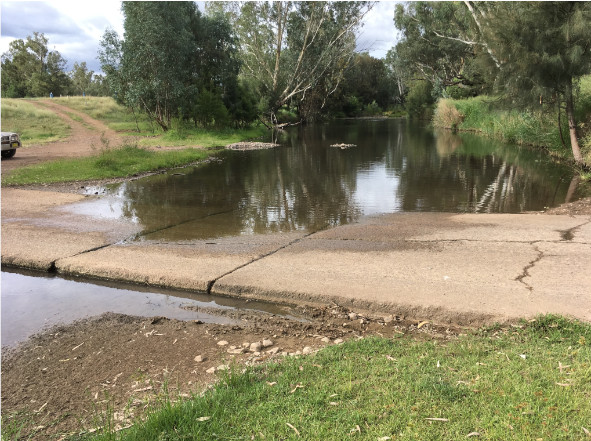

In [6]:
Image("/home/jovyan/work/visualisations/assets/Elfin_Crossing_22_3_2018.jpg")

# Elfin Crossing 16.4.2018 

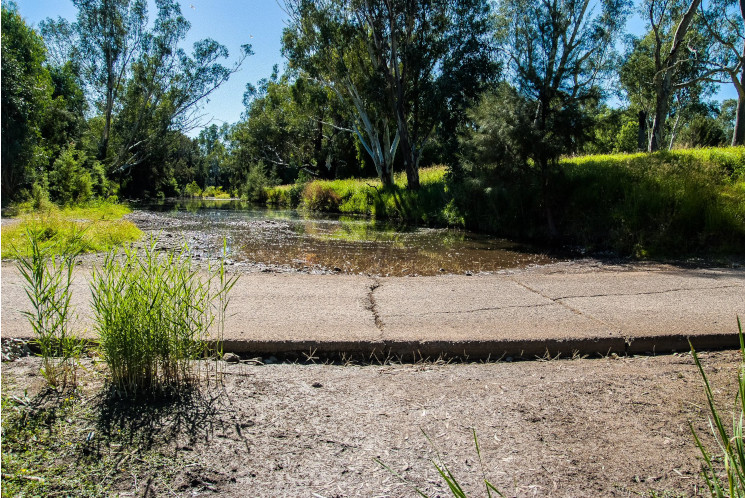

In [7]:
Image("/home/jovyan/work/visualisations/assets/Elfin_Crossing_16_4_2018.jpg")

# Elfin Crossing 14.5.2018 

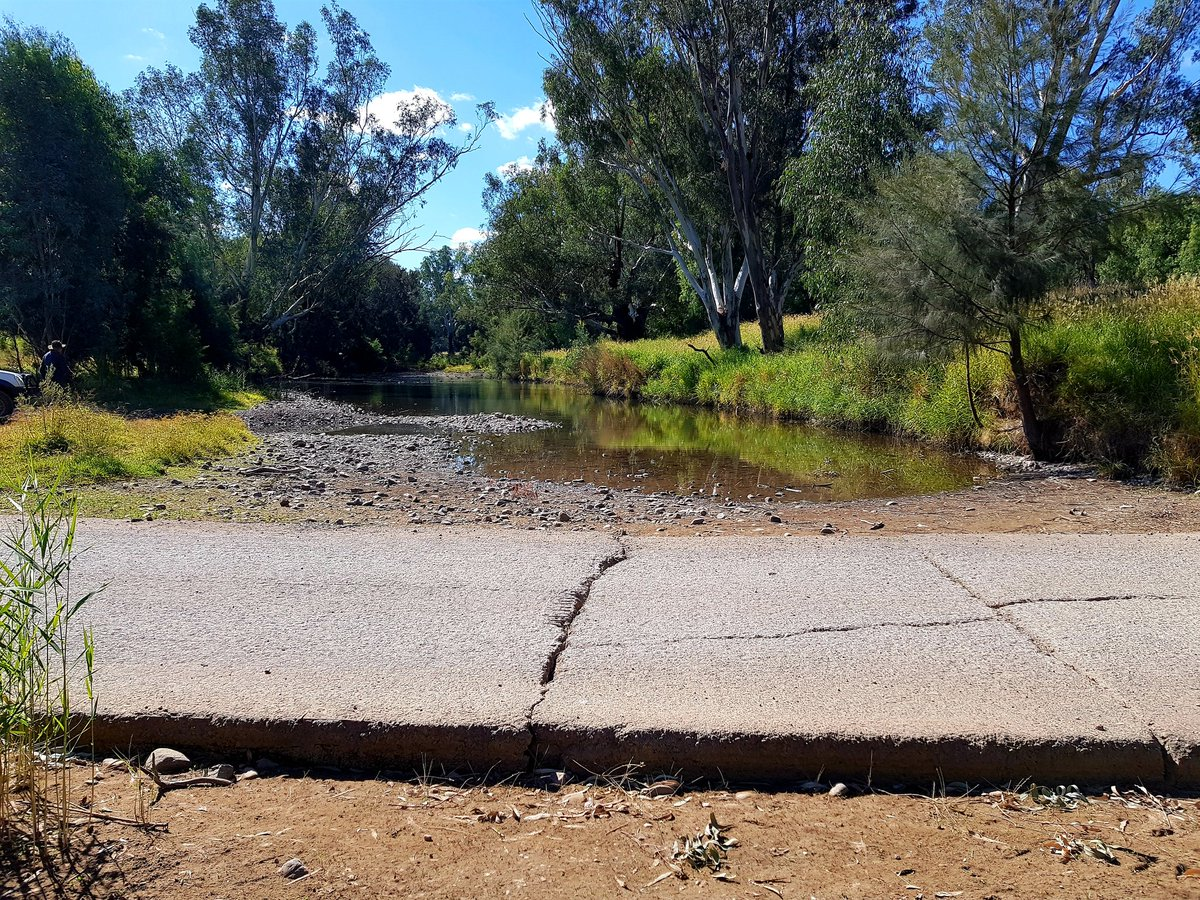

In [8]:
Image("/home/jovyan/work/visualisations/assets/Elfin_Crossing_14_5_2018.jpg")

# Elfin Crossing 19.9.2018

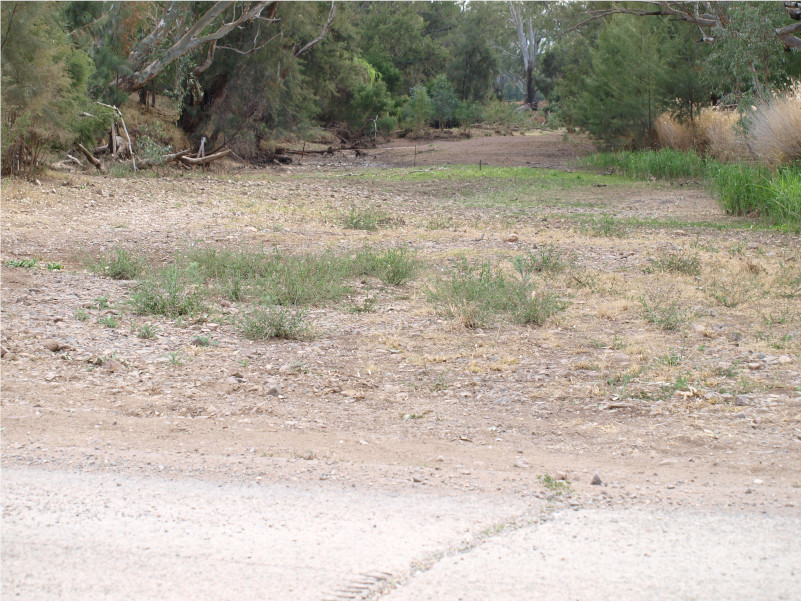

In [9]:
Image("/home/jovyan/work/visualisations/assets/Elfin_Crossing_19_9_2019.jpg")

<AxesSubplot:title={'center':'Elfin Crossing Correllation Heatmap'}>

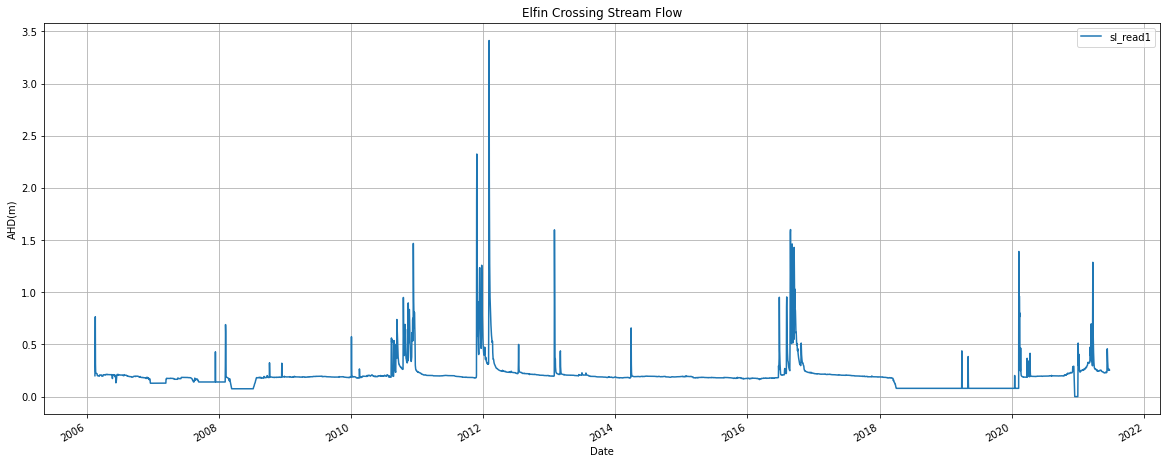

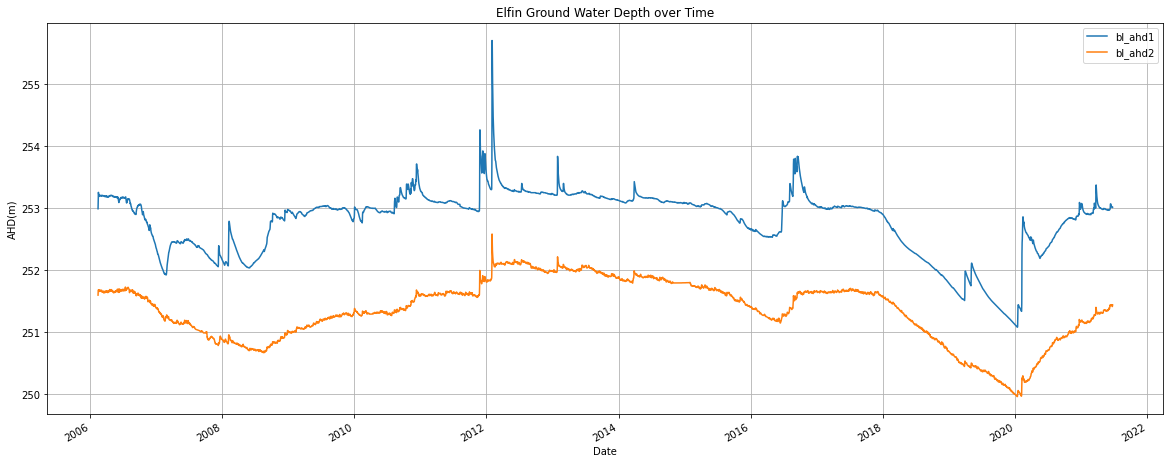

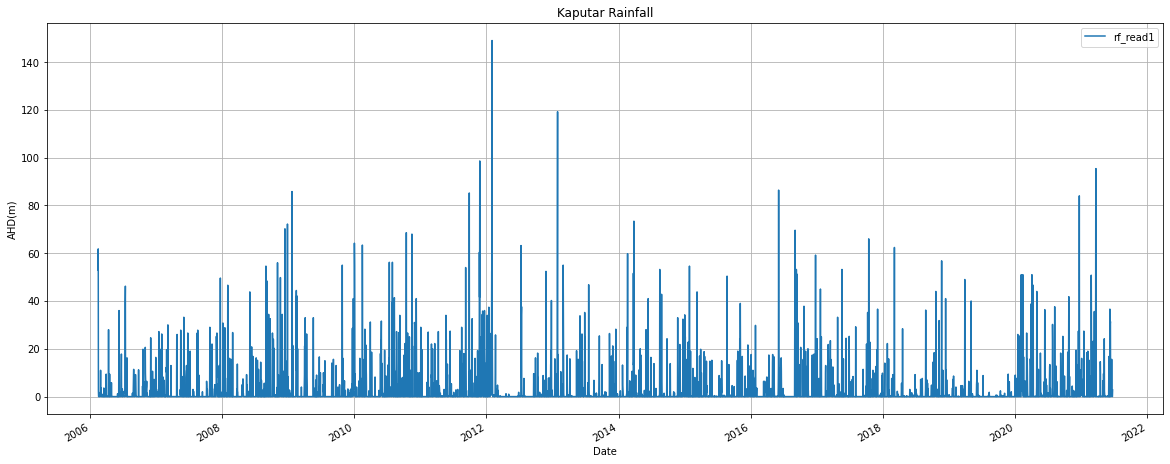

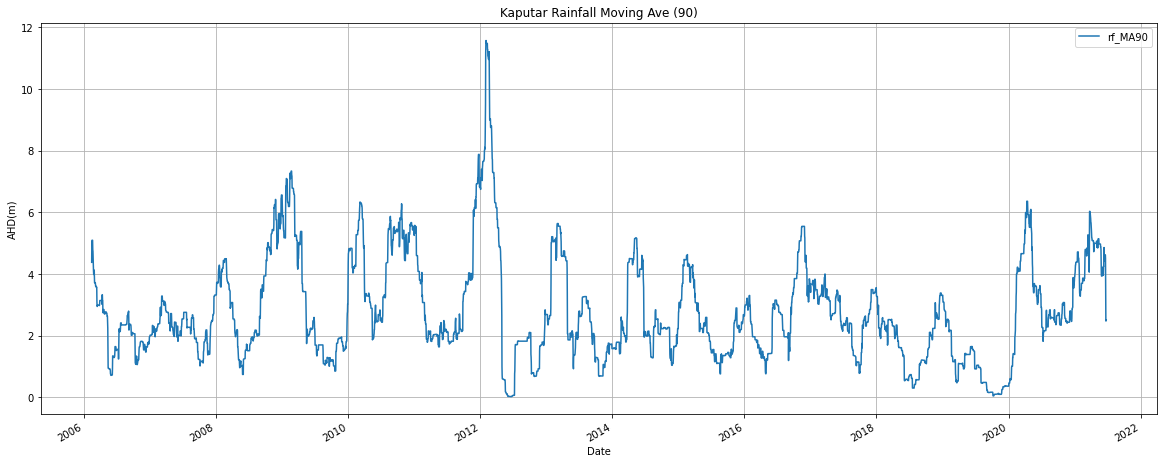

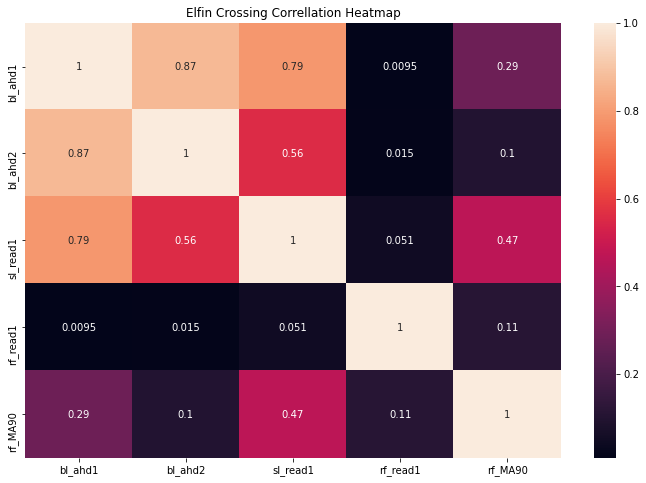

In [10]:
df1.plot(x='read_date', y='sl_read1',figsize=(20,8), grid=True, title='Elfin Crossing Stream Flow', xlabel='Date',ylabel='AHD(m)')
df1.plot(x='read_date', y=['bl_ahd1','bl_ahd2'],figsize=(20,8), grid=True, title='Elfin Ground Water Depth over Time', xlabel='Date',ylabel='AHD(m)')
df1.plot(x='read_date', y='rf_read1',figsize=(20,8), grid=True, title='Kaputar Rainfall', xlabel='Date',ylabel='AHD(m)')
df1.plot(x='read_date', y='rf_MA90',figsize=(20,8), grid=True, title='Kaputar Rainfall Moving Ave (90)', xlabel='Date',ylabel='AHD(m)')

df1_corr = df1.corr(method='spearman')
plt.figure(figsize=(12, 8))
plt.title("Elfin Crossing Correllation Heatmap")
sns.heatmap(df1_corr,annot=True)


<AxesSubplot:title={'center':'Green Gully Correllation Heatmap'}>

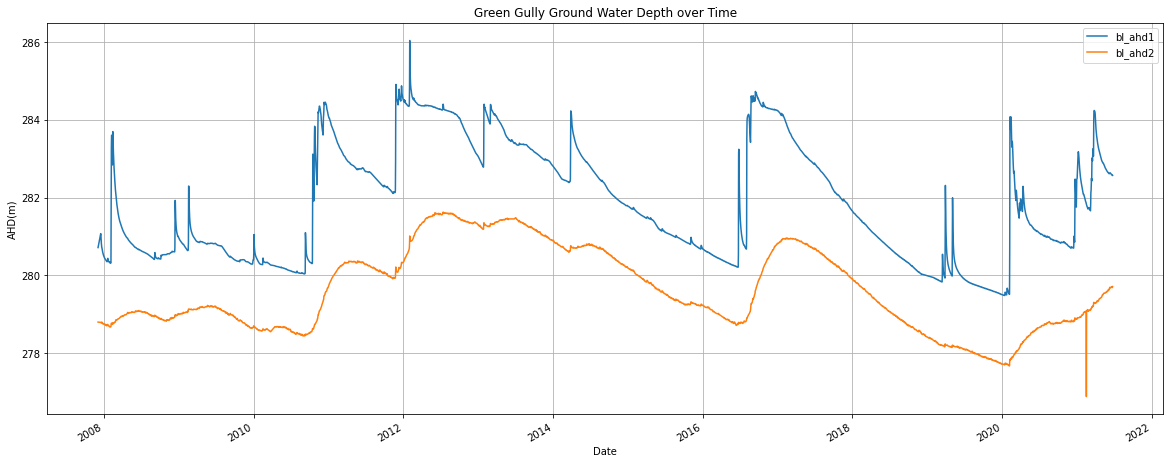

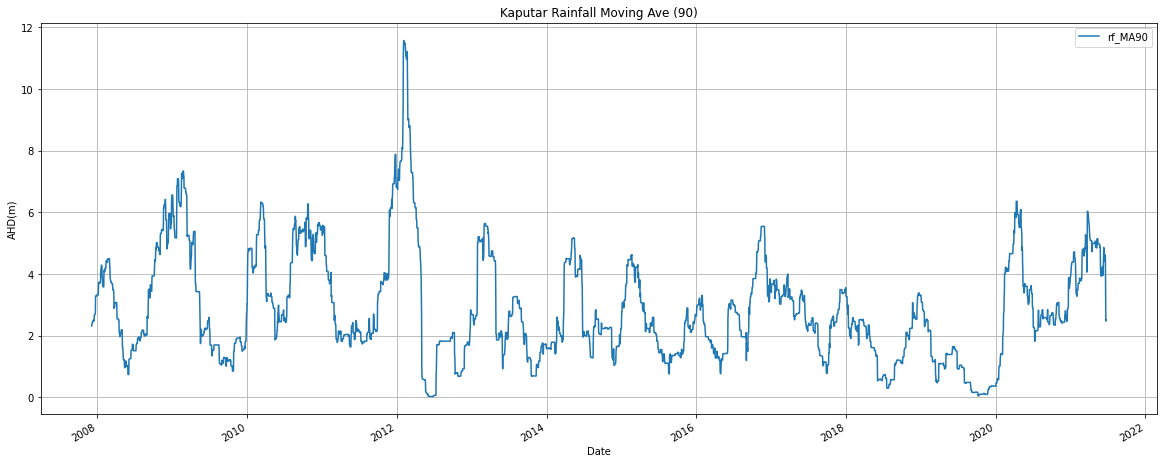

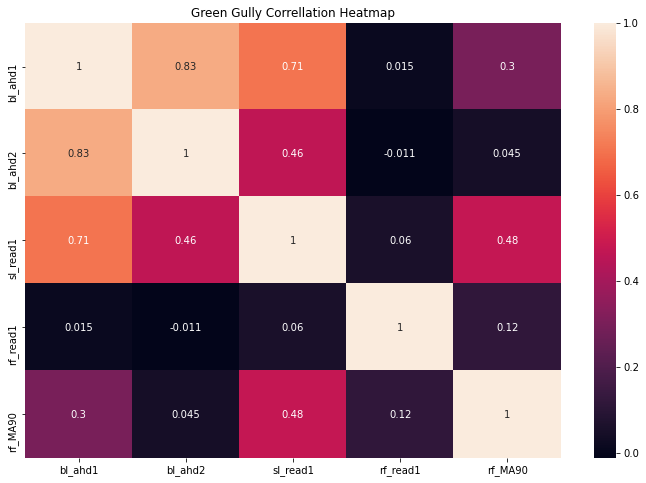

In [11]:
df2.plot(x='read_date', y=['bl_ahd1','bl_ahd2'],figsize=(20,8), grid=True, title='Green Gully Ground Water Depth over Time', xlabel='Date',ylabel='AHD(m)')
df2.plot(x='read_date', y='rf_MA90',figsize=(20,8), grid=True, title='Kaputar Rainfall Moving Ave (90)', xlabel='Date',ylabel='AHD(m)')



df2_corr = df2.corr(method='spearman')
plt.figure(figsize=(12, 8))
plt.title("Green Gully Correllation Heatmap")
sns.heatmap(df2_corr,annot=True)




# Stop here for summary heatmap



KeyError: 'bl_ahd2_dt7'

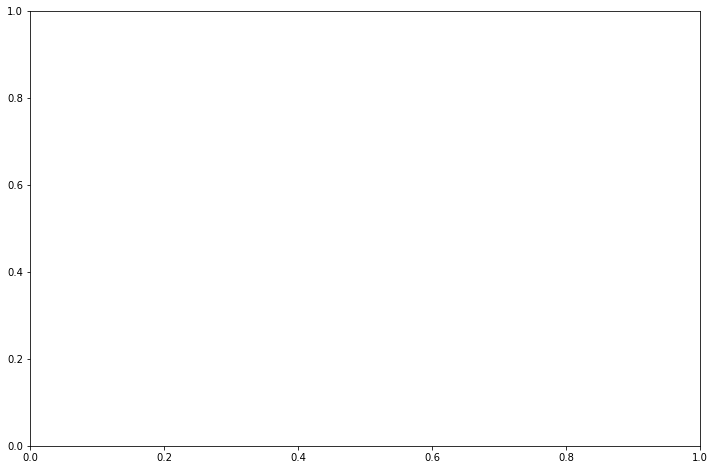

In [12]:
df1.plot.scatter(x='bl_ahd2_dt7', y='bl_ahd1_dt7', figsize=(12, 8), title="Elfin Crossing 7 day Delta", xlabel="GW967137.2.2", ylabel='GW967137.1.1',grid=True)
df2.plot.scatter(x='bl_ahd2_dt7', y='bl_ahd1_dt7', figsize=(12, 8), title="Green Gully 7 day Delta", xlabel='GW967138.2.2', ylabel='GW967138.1.1', grid=True)

plt.show()

In [13]:
df1.cov()

,bl_ahd1,bl_ahd2,sl_read1,rf_read1,rf_MA90
bl_ahd1,0.266903,0.217727,0.041165,0.377627,0.371644
bl_ahd2,0.217727,0.244550,0.022182,0.116363,0.133732
sl_read1,0.041165,0.022182,0.020439,0.297258,0.105678
rf_read1,0.377627,0.116363,0.297258,80.065990,2.316283
rf_MA90,0.371644,0.133732,0.105678,2.316283,2.778558


In [14]:
df2.cov()

,bl_ahd1,bl_ahd2,sl_read1,rf_read1,rf_MA90
bl_ahd1,2.170409,1.280842,0.105386,0.679673,0.825204
bl_ahd2,1.280842,1.115845,0.029980,-0.028814,0.133610
sl_read1,0.105386,0.029980,0.022847,0.332750,0.116128
rf_read1,0.679673,-0.028814,0.332750,84.915339,2.516077
rf_MA90,0.825204,0.133610,0.116128,2.516077,3.027323


In [15]:
df1_corr = df1.corr(method='spearman')

In [16]:
df1_corr

,bl_ahd1,bl_ahd2,sl_read1,rf_read1,rf_MA90
bl_ahd1,1.000000,0.870699,0.788887,0.009545,0.285241
bl_ahd2,0.870699,1.000000,0.557308,0.015303,0.101040
sl_read1,0.788887,0.557308,1.000000,0.050832,0.468547
rf_read1,0.009545,0.015303,0.050832,1.000000,0.110656
rf_MA90,0.285241,0.101040,0.468547,0.110656,1.000000


<AxesSubplot:title={'center':'Elfin Crossing Correllation Heatmap'}>

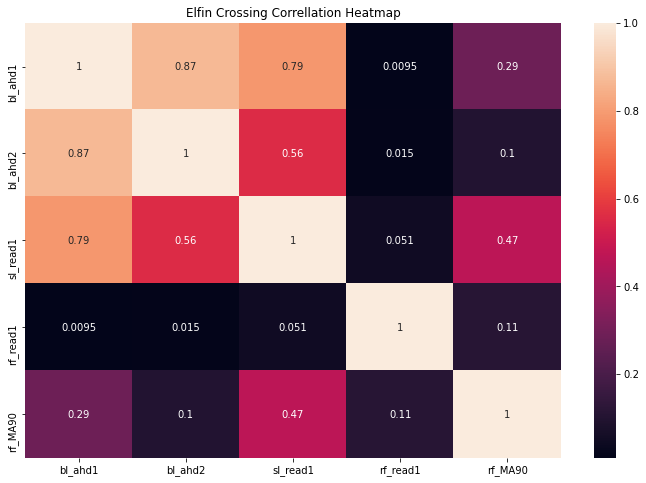

In [17]:
plt.figure(figsize=(12, 8))
plt.title("Elfin Crossing Correllation Heatmap")
sns.heatmap(df1_corr,annot=True)

In [18]:
df2_corr = df2.corr(method='spearman')

df2_corr

,bl_ahd1,bl_ahd2,sl_read1,rf_read1,rf_MA90
bl_ahd1,1.000000,0.833304,0.705144,0.015059,0.298532
bl_ahd2,0.833304,1.000000,0.463161,-0.010786,0.045251
sl_read1,0.705144,0.463161,1.000000,0.059777,0.478661
rf_read1,0.015059,-0.010786,0.059777,1.000000,0.118741
rf_MA90,0.298532,0.045251,0.478661,0.118741,1.000000


<AxesSubplot:title={'center':'Green Gully Correllation Heatmap'}>

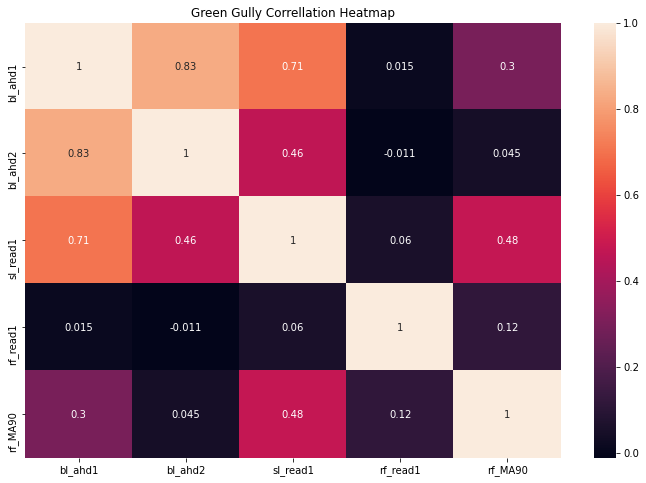

In [19]:


plt.figure(figsize=(12, 8))
plt.title("Green Gully Correllation Heatmap")
sns.heatmap(df2_corr, annot=True)

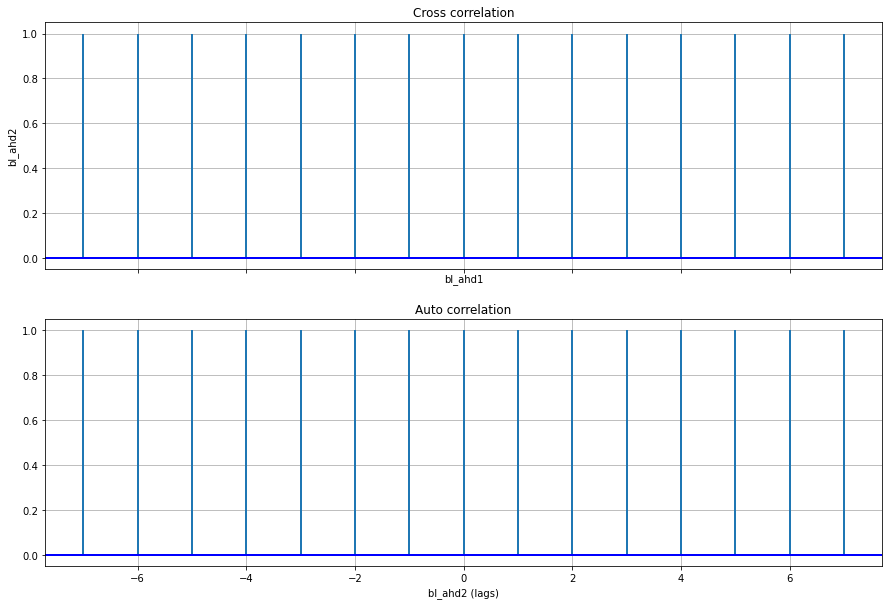

In [39]:
# https://www.geeksforgeeks.org/matplotlib-pyplot-xcorr-in-python/
# cross correlation functions measures the strength of the relationship between the relative movements of two variables

fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True,figsize=(15, 10))
ax1.set_ylabel('bl_ahd2')
ax1.set_xlabel('bl_ahd1')
ax1.set_title('Cross correlation')
ax1.xcorr(df2['bl_ahd1'], df2['bl_ahd2'], usevlines=True, maxlags=7, normed=True, lw=2)
ax1.axhline(0, color='blue', lw=2)
ax1.grid(True)

# autocorrelation measures a set of current values against past values to see if they correlate

ax2.set_xlabel('bl_ahd2 (lags)')
ax2.set_title('Auto correlation')
ax2.acorr(df2['bl_ahd2'], usevlines=True, normed=True, maxlags=7, lw=2)
ax2.axhline(0, color='blue', lw=2)
ax2.grid(True)

plt.show()


In [38]:
import scipy.signal as signal
def xcorr(x,y):
    """
    Perform Cross-Correlation on x and y
    x    : 1st signal
    y    : 2nd signal

    returns
    lags : lags of correlation
    corr : coefficients of correlation
    """
    corr = signal.correlate(x, y, mode="full")
    lags = signal.correlation_lags(len(x), len(y), mode="full")
    return lags, corr


x = df1['bl_ahd1'] 
y = df1['bl_ahd2']
lags,c = xcorr(x,y);
plt.figure()
plt.stem(lags,c)
plt.show()


AttributeError: module 'scipy.signal' has no attribute 'correlation_lags'